기존 ViT는 <ClS>에서 의미 벡터를 추출.
ViT로 이미지생성으로 구현해야 할듯. 어떻게 하지? CLS 부터 단어 생성처럼 순차적으로 생기나?

ViT segmentation은 trans UNet이라는게  존재 

Transformer for Semantic Segmentation
ViT encoder에 집어넣고 나오면,두가지 디코딩 방식 존재 Decoder는 Linear와 Masked 방식.

In [1]:
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
print("GPU is available:", tf.config.list_physical_devices('GPU'))

2025-11-20 16:45:35.217976: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-20 16:45:35.248688: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-20 16:45:36.016638: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


TensorFlow Version: 2.20.0
GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [23]:
# Transformers (Vision Transformer)
from transformers import TFViTModel

/home/JGY/anaconda3/envs/vit3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
# System utilities and file handling
import os
import random
from glob import glob
import math
import itertools
import random
# Numerical and tabular data
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and deep learning
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Image handling
from PIL import Image
import cv2
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D, Dense, UpSampling2D, Flatten, Reshape,GlobalAveragePooling2D,Dropout,BatchNormalization, Conv2DTranspose

In [8]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Dataset/config
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
#trying our basic unet for segmentation

import glob
from sklearn.model_selection import train_test_split

img_width=224  #128
img_height=224  #128
img_channels=3

# changed
base_path='/home/JGY/mri_cnn/data/segmentation_Dataset/brisc2025/segmentation_task'

train_image_path= os.path.join(base_path,'train/images')
train_mask_path= os.path.join(base_path,'train/masks')
test_image_path= os.path.join(base_path,'test/images')
test_mask_path= os.path.join(base_path,'test/masks')

def load_preprocess(image_dir, mask_dir):
  image_files=sorted(glob.glob(os.path.join(image_dir, '*.*')))
  mask_files=sorted(glob.glob(os.path.join(mask_dir, '*.*')))
  if len(image_files) != len(mask_files):
    print(f"Error: Mismatch in file counts")
    print(f"Images found: {len(image_files)}, masks found = {len(image_files)}")
    return None, None
  X= []
  Y=[]
  print(f"Loading{len(image_files)}images and masks..")

  for img_path, mask_path in zip(image_files, mask_files):
    try:
      img=cv2.imread(img_path, cv2.IMREAD_COLOR)
      img=cv2.resize(img, (img_width, img_height))
      img=img/255.0
      mask= cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
      mask=cv2.resize(mask,(img_width, img_height))
      mask=(mask>128).astype(np.float32)
      X.append(img)
      Y.append(mask)
    except Exception as e:
     print(f"Error loading image or mask: {e}")

  X=np.array(X)
  Y=np.array(Y)
  Y=np.expand_dims(Y, axis=-1)

  return X, Y

X_train, y_train= load_preprocess(train_image_path, train_mask_path)
# X_train과 y_train을 80-20 비율로 분리
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42  #, stratify=y_train
)

X_test, y_test= load_preprocess(test_image_path, test_mask_path)
print(f"\nData loading complete.")

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape:   {X_val.shape}")
print(f"y_val shape:   {y_val.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")



Loading3933images and masks..
Loading860images and masks..

Data loading complete.
X_train shape: (3146, 224, 224, 3)
y_train shape: (3146, 224, 224, 1)
X_val shape:   (787, 224, 224, 3)
y_val shape:   (787, 224, 224, 1)
X_test shape:  (860, 224, 224, 3)
y_test shape:  (860, 224, 224, 1)


In [2]:
# Flatten filepaths + labels
BASE_PATH = '/home/JGY/mri_cnn/data/segmentation_Dataset/brisc2025/segmentation_task/train'

filepaths, labels = [], []
for c in CLASSES:
    paths = glob(os.path.join(BASE_PATH, c, "*.jpg"))
    filepaths.extend(paths)
    labels.extend([c] * len(paths))

df = pd.DataFrame({"filepath": filepaths, "label": labels})
df["label_id"] = df["label"].map(class_to_id)
print(df.shape)
df.head()

# load test data set
BASE_PATH_TEST = '/home/JGY/mri_cnn/data/segmentation_Dataset/brisc2025/segmentation_task/test'

filepaths_test, labels_test = [], []
for c in CLASSES:
    paths = glob(os.path.join(BASE_PATH_TEST, c, "*.jpg"))
    filepaths_test.extend(paths)
    labels_test.extend([c] * len(paths))

df_test = pd.DataFrame({"filepath": filepaths_test, "label": labels_test})
df_test["label_id"] = df_test["label"].map(class_to_id)   # label(test)를 보고 map(class_to_id)를 사용해서 label_id 라는 새로운 column에 mapping 하라
print(df_test.shape)
df_test.head()

NameError: name 'CLASSES' is not defined

In [13]:
X_trains = X_train / np.max(X_train)
#y_train..?
X_tests = X_test / np.max(X_train)
X_vals = X_val/np.max(X_train)
print('X_tests[0] min_Max:',X_tests[0].min(), X_tests[0].max())
print('y_tests[0] min_Max:',y_test[0].min(), y_test[0].max())  #검정/흰색
df_train = X_trains
df_val = X_vals
df_test = X_tests

X_tests[0] min_Max: 0.0 0.9607843137254902
y_tests[0] min_Max: 0.0 1.0


In [ ]:
# Split 1: train_val vs test (15% test)
#df_trainval, df_test = train_test_split(
#    df, test_size=0.15, stratify=df["label_id"], random_state=SEED
#)

# Split 2: train vs val (val ~15% of total -> 15/85 ≈ 0.176 of train_val)
df_train, df_val = train_test_split(
    df, test_size=0.15, stratify=df["label_id"], random_state=SEED
)

for name, dfx in [("train", df_train), ("val", df_val), ("test", df_test)]:
    per_class = dfx["label"].value_counts().to_dict()
    print(f"{name:>5} -> {len(dfx)} images | per class: {per_class}")

2025-11-20 16:54:13.039739: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node augmentation_1/random_rotation_4_1/Add/_18}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-11-20 16:54:13.039770: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node GroupCrossDeviceControlEdges_0/NoOp/_33}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-11-20 16:54:13.039790: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6987506194653985461
2025-11-20 16:54:13.039793: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 4542625604929600069
2025-11-20 16:54:13.039906: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 15498425232880669530
2025-11-20 16:54:13.039

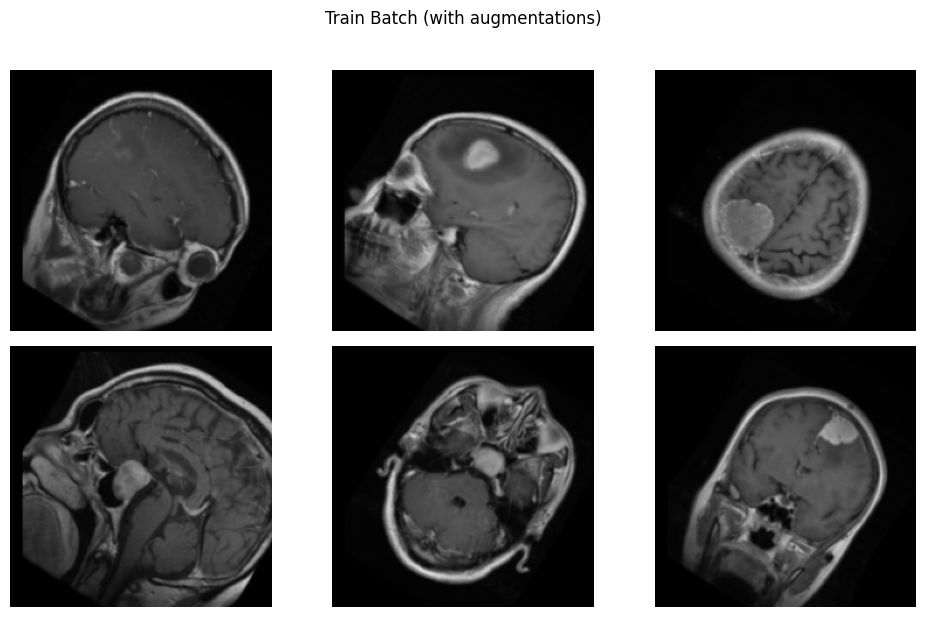

In [15]:
'''
def decode_resize_norm(path, label_id):
    img = tf.io.read_file(path)  # 바이너리 raw file로 읽어옴
    img = tf.io.decode_jpeg(img, channels=1)             # 바이너리 raw data를 jpeg로 변환 , read grayscale
    img = tf.image.resize(img, IMG_SIZE)                 #  -> IMG_SIZE (224,224)
    img = tf.cast(img, tf.float32) / 255.0               # [0,1] 픽셀값 정규화
    img = tf.image.grayscale_to_rgb(img)                 # replicate to 3 channels (224,224,3)을 기대하는 모델로 맞추기 위함.
    
    return img, tf.one_hot(label_id, depth=len(CLASSES)) # 처리된 img, one-hot label 반환

def make_ds(dfx, shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices(  # dfx의 filepath, label_id 열을 사용해 tensor로 변환
        (dfx["filepath"].values, dfx["label_id"].values)
    )
    ds = ds.map(decode_resize_norm, num_parallel_calls=AUTOTUNE) #ds tensor의 각 원소에 decode_resize_norm 적용
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dfx), seed=SEED, reshuffle_each_iteration=True)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)  # augmentation이 필요하면 적용?
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)  # ds를 배치로 묶고, 다음 배치 미리 로드?? 성능 최적화??
    return ds
    '''
def make_ds(dfx,dfy ,shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices(  # dfx의 filepath, label_id 열을 사용해 tensor로 변환
        (dfx, dfy)
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dfx), seed=SEED, reshuffle_each_iteration=True)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)  # augmentation이 필요하면 적용?
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)  # ds를 배치로 묶고, 다음 배치 미리 로드?? 성능 최적화??
    return ds


# Gentle, clinically plausible augmentations
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"), #수평
    tf.keras.layers.RandomRotation(0.26, fill_mode="constant", fill_value=0.0),  #15도 무작위 회전
    tf.keras.layers.RandomZoom(0.05, fill_mode="constant", fill_value=0.0), #0.05 줌인/줌아웃
    tf.keras.layers.RandomTranslation(0.05, 0.05, fill_mode="constant", fill_value=0.0), #가로세로 0.05 범위 내 무작위 이동
    tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, 0.0, 1.0)),  # 0.0- 1.0 범위로 픽셀값 제한.
], name="augmentation")  # aumentation layer sequence를 정의???

train_ds = make_ds(df_train,y_train, shuffle=True,  augment=True)
val_ds   = make_ds(df_val,y_val,   shuffle=False, augment=False)
test_ds  = make_ds(df_test,y_test,  shuffle=False, augment=False)

# Quick visual sanity check after augmentation
images, labels = next(iter(train_ds))
plt.figure(figsize=(10, 6))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy(), cmap="gray")
    plt.axis("off")
    cls_idx = tf.argmax(labels[i]).numpy()
    #plt.title(CLASSES[cls_idx])
plt.suptitle("Train Batch (with augmentations)", y=1.02)
plt.tight_layout()
plt.show()

In [29]:
#NUM_CLASSES = len(CLASSES)

# Map [0,1] -> [-1,1] before ViT : ViT가 요구하는 입력 범위.
class ViTPreprocess(tf.keras.layers.Layer):
    def call(self, x):
        return (x - 0.5) / 0.5

# Wrapper that makes the backbone appear in model.summary()
class HFViTLayer(tf.keras.layers.Layer):  #Hugging face의 ViT model을 keras layer로 wrapping => keras layer?
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone   #pre-trained ViT 모델 내부 변수 저장? 

    def call(self, x, training=False):
        # ViT expects NCHW (channels-first), not NHWC
        x = tf.transpose(x, perm=[0, 3, 1, 2])  # Hugging face 요구조건에 따라 (N,C,H,W) 형식 변환 
        outputs = self.backbone(pixel_values=x, training=training)  #training arg = 학습모드/추론모드
        return outputs.pooler_output  # [batch, 768] 1차원 벡터로 표현된 하나의 이미지. 맨 앞에 있는 CLS 토큰은 학습과정중에 이미지 전체를 대표하는 특징 백터로 학습된다.

# Load pretrained ViT (ImageNet-21k)
vit_backbone = TFViTModel.from_pretrained(  # 모델객체 불러오기
    "google/vit-base-patch16-224-in21k", 
    from_pt=False, # 가중치를 Tensorflow 형식으로 불러옴
    use_safetensors=False  # 텐서에서 써야할듯.
)

# Phase 1: freeze backbone (train only the classification head)
vit_backbone.trainable = False  #사전 훈련된 모델의 가중치 고정
initial_h, initial_w = 7, 7                                                                                                                                               
initial_c = 256  # Initial number of channels  
output_shape = (224,224,1)

inputs = tf.keras.Input(shape=(*IMG_SIZE, 3), dtype=tf.float32)  #(224,224) unpacking, 
x = ViTPreprocess()(inputs)  #pixel [-1,1]
x = HFViTLayer(vit_backbone)(x) # ViT에 집어넣음
x = tf.keras.layers.Dropout(0.2)(x)                                                                                                                            
                                                                                                                                                                           
#input_vector = Input(shape=input_shape)                                                                                                                                   
                                                                                                                                                                           
# 1. Project and Reshape                                                                                                                                                  
x = Dense(initial_h * initial_w * initial_c, activation='relu')(x)                                                                                             
x = BatchNormalization()(x)                                                                                                                                               
x = Reshape((initial_h, initial_w, initial_c))(x)                                                                                                                                                                                                                                                                                                   
# 2. Upsample to the target dimensions                                                                                                                                    
# Current shape: (7, 7, 256)                                                                                                                                              
# Upsample to (14, 14, 128)                                                                                                                                               
x = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu')(x)                                                                                  
x = BatchNormalization()(x)                                                                                                                                                                                                                                                                                                                       
# Upsample to (28, 28, 64)                                                                                                                                                
x = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)                                                                                   
x = BatchNormalization()(x)                                                                                                                                               
# Upsample to (56, 56, 32)                                                                                                                                                
x = Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu')(x)                                                                                   
x = BatchNormalization()(x) 
# Upsample to (112, 112, 16)                                                                                                                                             
x = Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='relu')(x)                                                           
x = BatchNormalization()(x)                                                                                                                                              
# Upsample to (224, 224, 3)                                                                                                                                              ▀                                                                                      
outputs = Conv2DTranspose(output_shape[-1], kernel_size=3, strides=2, padding='same', activation='sigmoid')(x) 


#outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)  #바로 얕게 하네? 

model = tf.keras.Model(inputs, outputs, name="vit_brain_mri")  # inpur에서 output까지 추적하라.

# Baseline compile (will be overridden by schedulers below)
model.compile(  # 아담, loss, 평가지표 확정??
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Model: "vit_brain_mri"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vi_t_preprocess_3               │ (None, 224, 224, 3)    │             0 │
│ (ViTPreprocess)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hf_vi_t_layer_3 (HFViTLayer)    │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12544)          │     9,646,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 14, 14, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 56, 56, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 112, 112, 16)   │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 112, 112, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 224, 224, 1)    │           145 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,089,537 (38.49 MB)

 Trainable params: 10,063,969 (38.39 MB)

 Non-trainable params: 25,568 (99.88 KB)

In [30]:
# 에포크당 훈련 스텝?
train_steps = int(tf.data.experimental.cardinality(train_ds).numpy()) # dataset 배치 tensor로 반환 -> numpy로 변환 -> int로 계산

class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):  #스케쥴러 : warmup= 학습률 점차 증가 + cosine decay 학습률 점차 감쇠
    # 기본 클레스 LearningRateSchedule 상속
    """
    Step-wise schedule: linear warmup -> cosine decay.
    """
    def __init__(self, base_lr, total_steps, warmup_steps=0, min_lr=0.0):
        super().__init__()
        self.base_lr = base_lr  #warm up 종료시점 최대 학습률
        self.total_steps = total_steps  #학습고정의 총 스텝 : 에폭이 아닌 전체 데이터 셋에 대한 ? 1배치 = 1스텝
        self.warmup_steps = warmup_steps # 웜업 스텝 수 
        self.min_lr = min_lr #최소 학습률

    def __call__(self, step):  # 매스탭 이후 호출되는 함수
        step = tf.cast(step, tf.float32) #현재 몇 스텝? 옵티마이저가 전달 , cast를 통해 소수형으로 변환

        # Warmup (linear)
        if self.warmup_steps > 0: #웜업을 하라!
            warmup_lr = self.min_lr + (self.base_lr - self.min_lr) * (step / self.warmup_steps) # step에 비례해 min -> max(base)까지 증가
            lr = tf.where(step < self.warmup_steps, warmup_lr, 0.0)  # 아직 웜업중이면 warmup 끝났으면 0.0 을 warmup에 집어넣어서 종료되도록
        else:
            lr = 0.0

        # Cosine decay after warmup
        progress = tf.clip_by_value(
            (step - self.warmup_steps) / tf.maximum(1.0, self.total_steps - self.warmup_steps), # 0-1 값으로 진행도, 웜업비율 제외하고 
            0.0, 1.0  #0과 1사이 진행도, 웜업구간=음수는 0으로
        )
        cosine_lr = self.min_lr + 0.5 * (self.base_lr - self.min_lr) * (1 + tf.cos(math.pi * progress)) # 코사인 항은 2->0으로 
        return tf.where(step >= self.warmup_steps, cosine_lr, lr)  #웜업이면 웜업 반환, 끝났으면 코사인 반환

In [31]:
EPOCHS_HEAD = 15  # 15 에폭, 전체 훈련 데이터셋 = 1 epoch
total_steps_head = train_steps * EPOCHS_HEAD  # 1 에폭당 스텝 수

sched_head = WarmUpCosine(  #이전에 정의한 웜업 코사인 객체 
    base_lr=3e-4,  #최대 학습률
    total_steps=total_steps_head,
    warmup_steps=int(0.10 * total_steps_head),  # 전체 스텁(에폭* 스텝)의 10%를 웜업으로
    min_lr=3e-5  #작아져봤자 이정도 (최소에서 최대까지 웜업으로 올라간다)
)

opt_head = tf.keras.optimizers.AdamW(  # 옵티마이저 바꿈?
    learning_rate=sched_head,  # 기존 learning rate 클레스 상속받아서 새로운거 사용
    weight_decay=1e-4,  
    clipnorm=1.0  #gradient clipping -> 그래디언트 폭주를 막는다. 그래디언트의 L2 norm을 1.0으로 제한?
)
loss_ls = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)  # 원-핫으로 0,1 확정 대신 label smoothing

model.compile(optimizer=opt_head, loss=loss_ls, metrics=["accuracy"])  

cb_head = [
    ModelCheckpoint("model/segmentation_vit.weights.h5", save_best_only=True,
                    save_weights_only=True, monitor="val_accuracy", verbose=1),  # val_accuracy가 개선되었을 때만 저장?, 근데 가중치만 저장...
    EarlyStopping(monitor="val_accuracy", patience=5,
                  restore_best_weights=True, verbose=1),  # 훈련이 중단되었을 때 가장 성능이 좋았던 시점으로 모델 복원.
]

history_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD,
    callbacks=cb_head,
    verbose=1
)

Epoch 1/15


/home/JGY/anaconda3/envs/vit3/lib/python3.10/site-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 224, 224, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)
2025-11-20 17:01:34.307423: I external/local_xla/xla/service/service.cc:163] XLA service 0x7b8d780026a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-20 17:01:34.307446: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2025-11-20 17:01:34.662786: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-20 17:01:35.884507: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Lo

 3/99 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.5098 - loss: 0.0000e+00 

I0000 00:00:1763625703.867091  543036 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5125 - loss: 0.0000e+00

2025-11-20 17:01:52.413497: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2907', 16 bytes spill stores, 16 bytes spill loads

2025-11-20 17:01:52.549962: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2467', 16 bytes spill stores, 16 bytes spill loads

2025-11-20 17:01:52.562377: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2907', 4 bytes spill stores, 4 bytes spill loads

2025-11-20 17:01:52.582763: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 88 bytes spill stores, 88 bytes spill loads

2025-11-20 17:01:52.628798: I external/local_

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.5127 - loss: 0.0000e+00

2025-11-20 17:02:03.326436: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_634', 68 bytes spill stores, 68 bytes spill loads

2025-11-20 17:02:03.417230: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_634', 16 bytes spill stores, 16 bytes spill loads

2025-11-20 17:02:03.465303: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_725', 112 bytes spill stores, 112 bytes spill loads

2025-11-20 17:02:03.475207: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 88 bytes spill stores, 88 bytes spill loads

2025-11-20 17:02:03.479688: I external/local


Epoch 1: val_accuracy improved from None to 0.31008, saving model to model/segmentation_vit.weights.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 36s 222ms/step - accuracy: 0.5191 - loss: 0.0000e+00 - val_accuracy: 0.3101 - val_loss: 0.0000e+00
Epoch 2/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6130 - loss: 0.0000e+00
Epoch 2: val_accuracy improved from 0.31008 to 0.76236, saving model to model/segmentation_vit.weights.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.6713 - loss: 0.0000e+00 - val_accuracy: 0.7624 - val_loss: 0.0000e+00
Epoch 3/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7973 - loss: 0.0000e+00
Epoch 3: val_accuracy improved from 0.76236 to 0.90843, saving model to model/segmentation_vit.weights.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.8177 - loss: 0.0000e+00 - val_accuracy: 0.9084 - val_loss: 0.0000e+00
Epoch 4/15
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8639 - loss: 0.0000e+00
Epoch 4: val_accuracy improved from 0.90843

In [32]:
# Unfreeze last transformer blocks for targeted adaptation
for layer in vit_backbone.layers[-12:]:
    layer.trainable = True

EPOCHS_FT = 12
total_steps_ft = train_steps * EPOCHS_FT

sched_ft = WarmUpCosine(
    base_lr=5e-4,
    total_steps=total_steps_ft,
    warmup_steps=int(0.20 * total_steps_ft),
    min_lr=1e-5
)

opt_ft = tf.keras.optimizers.AdamW(
    learning_rate=sched_ft,
    weight_decay=1e-4,
    clipnorm=1.0
)

model.compile(optimizer=opt_ft, loss=loss_ls, metrics=["accuracy"])

cb_ft = [
    ModelCheckpoint("model/segmentation_vit_finetune.weights.h5", save_best_only=True,
                    save_weights_only=True, monitor="val_accuracy", verbose=1),
    EarlyStopping(monitor="val_accuracy", patience=4,
                  restore_best_weights=True, verbose=1),
]

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FT,
    callbacks=cb_ft,
    verbose=1
)

Epoch 1/12
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.8552 - loss: 0.0000e+00
Epoch 1: val_accuracy improved from None to 0.86864, saving model to model/segmentation_vit_finetune.weights.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 28s 192ms/step - accuracy: 0.8580 - loss: 0.0000e+00 - val_accuracy: 0.8686 - val_loss: 0.0000e+00
Epoch 2/12
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8626 - loss: 0.0000e+00
Epoch 2: val_accuracy improved from 0.86864 to 0.90215, saving model to model/segmentation_vit_finetune.weights.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.8629 - loss: 0.0000e+00 - val_accuracy: 0.9022 - val_loss: 0.0000e+00
Epoch 3/12
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8666 - loss: 0.0000e+00
Epoch 3: val_accuracy improved from 0.90215 to 0.92327, saving model to model/segmentation_vit_finetune.weights.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.8655 - loss: 0.0000e+00 - val_accuracy: 0.9233 - val_loss: 0.0000e+00
Epoch 4/12
98/99

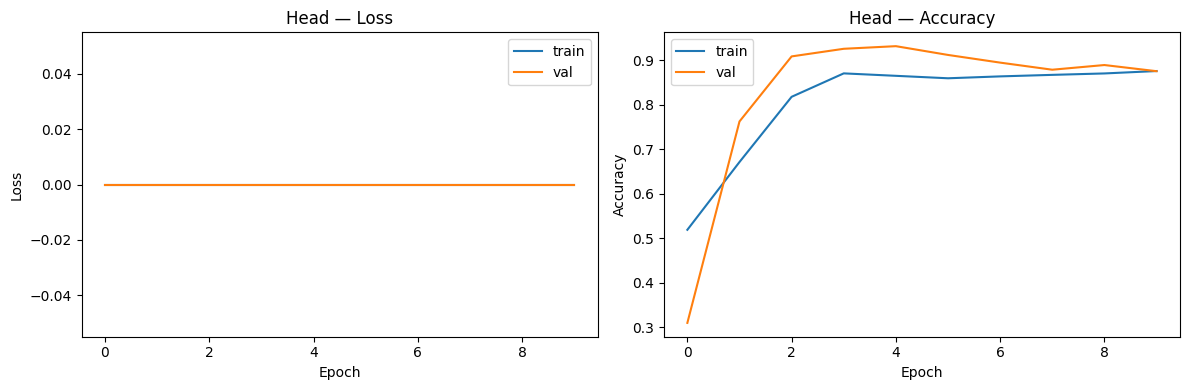

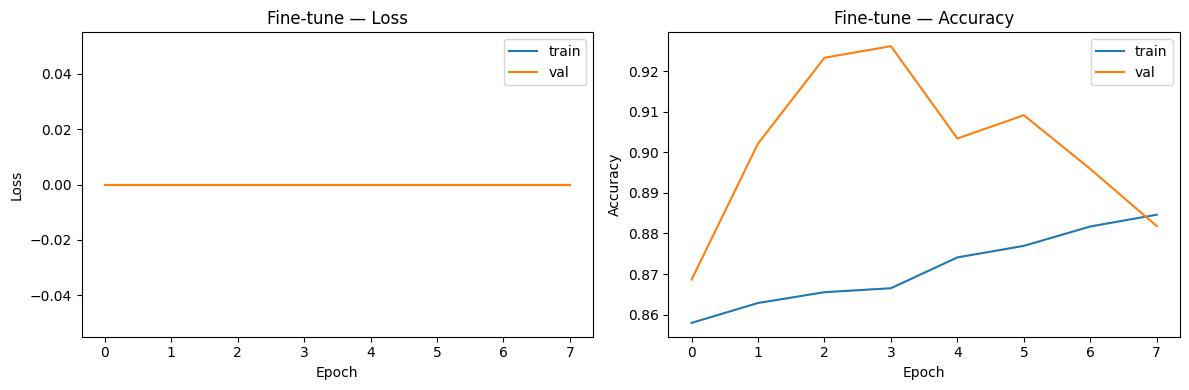

In [33]:
def plot_history(h, title_prefix=""):
    hist = h.history
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(hist["loss"], label="train")
    plt.plot(hist["val_loss"], label="val")
    plt.title(f"{title_prefix}Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(hist["accuracy"], label="train")
    plt.plot(hist["val_accuracy"], label="val")
    plt.title(f"{title_prefix}Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

    plt.tight_layout(); plt.show()

plot_history(history_head, "Head — ")
try:
    plot_history(history_ft, "Fine-tune — ")
except NameError:
    pass

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

2025-11-20 17:06:20.871407: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_829', 16 bytes spill stores, 16 bytes spill loads

2025-11-20 17:06:20.872342: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_603', 16 bytes spill stores, 16 bytes spill loads

2025-11-20 17:06:21.179930: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_603', 68 bytes spill stores, 68 bytes spill loads

2025-11-20 17:06:21.391247: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_478', 112 bytes spill stores, 112 bytes spill loads

2025-11-20 17:06:21.439784: I external/loc

27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 220ms/step


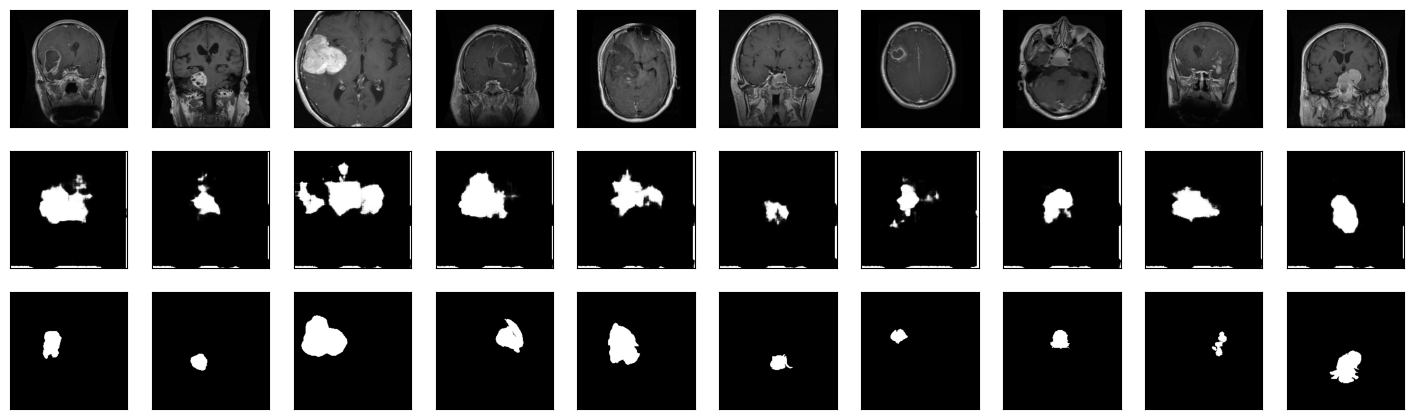

In [34]:
#check performance of autoencoder
model.load_weights('model/segmentation_vit_finetune.weights.h5')
#decoded_val_images = autoencoder_aug.predict(X_vals)
decoded_test_images = model.predict(X_tests)

n_images = 10
test_images = np.random.randint(0, X_tests.shape[0], size = n_images)
plt.figure(figsize=(18,18))
for i, image_index in enumerate(test_images):
  # input images
  ax = plt.subplot(10,10, i + 1)
  plt.imshow(X_tests[image_index],cmap='gray')
  plt.xticks(())
  plt.yticks(())

  # Decoded val
  ax = plt.subplot(10,10, i + 1 + n_images )
  plt.imshow(decoded_test_images[image_index],cmap='gray')
  plt.xticks(())
  plt.yticks(())
   # Decoded val
  ax = plt.subplot(10,10, i + 1 + 2*n_images )
  plt.imshow(y_test[image_index],cmap='gray')
  plt.xticks(())
  plt.yticks(())
  